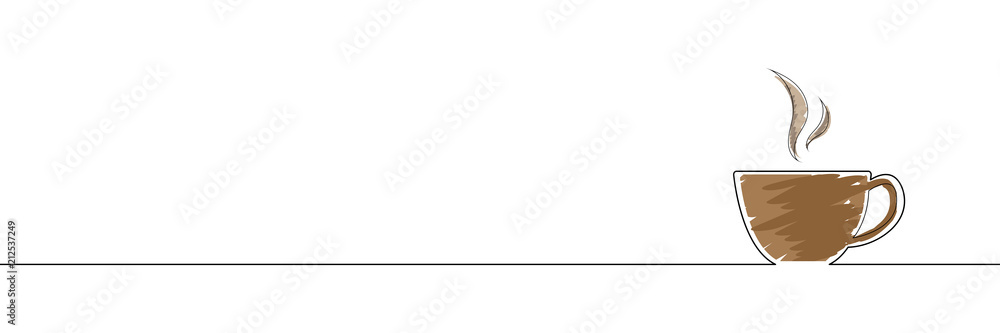

## **“Brewing Insights: Time Series Analysis and Predictive Modeling of Coffee Prices"**
### **Intro:**
This data science project delves into the world of coffee prices using a detailed time series analysis. By examining historical data including low, high, closing, opening prices, and volume, the study aims to uncover patterns and trends in the coffee market. Through advanced predictive modeling, the project seeks to forecast future price movements, offering valuable insights for those involved in the coffee industry. This exploration highlights the potential of data-driven decision-making and provides a nuanced understanding of the factors influencing coffee prices over time.

### **Libraries:**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import aic
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor


### **Data Wrangling:**

In [3]:
df = pd.read_csv('coffee.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5746 entries, 0 to 5745
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      5746 non-null   object 
 1   Open      5746 non-null   float64
 2   High      5746 non-null   float64
 3   Low       5746 non-null   float64
 4   Close     5746 non-null   float64
 5   Volume    5746 non-null   int64  
 6   Currency  5746 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 314.4+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Volume
count,5746.000000,5746.000000,5746.000000,5746.000000,5746.000000
mean,127.267635,128.847034,125.784669,127.215567,8807.178907
std,50.569425,51.164948,49.851487,50.506519,9612.789034
min,41.500000,42.000000,41.500000,41.500000,0.000000
25%,98.800000,100.112500,97.862500,98.650000,61.000000
50%,120.400000,121.600000,118.950000,120.250000,7008.000000
75%,144.800000,146.000000,143.000000,144.337500,14497.750000
max,305.300000,306.250000,304.000000,304.900000,62045.000000


#### Convert Date from object to datetime type:


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)

Date        datetime64[ns]
Open               float64
High               float64
Low                float64
Close              float64
Volume               int64
Currency            object
dtype: object


In [7]:
unique_counts = df.nunique()
unique_percents = (unique_counts / len(df)) * 100
print(unique_percents)

Date        100.000000
Open         43.247477
High         44.796380
Low          45.057431
Close        47.024017
Volume       64.601462
Currency      0.017403
dtype: float64


In [8]:
ranges = df.select_dtypes(include=['number']).agg(['min', 'max'])
print(ranges)

      Open    High    Low  Close  Volume
min   41.5   42.00   41.5   41.5       0
max  305.3  306.25  304.0  304.9   62045


In [9]:
missing_values = df.isnull().sum()

print(missing_values)

# data wrangling end

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
dtype: int64


#### No Missing Values found

### **Exploratory Data Analysis:**

In [13]:
column_info = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': df.dtypes,
    'Unique Values Count': df.nunique(),
    'Unique Values Percent': (df.nunique() / len(df)) * 100
})

print("Column Information:")
print(column_info)

Column Information:
         Column Name       Data Type  Unique Values Count  \
Date            Date  datetime64[ns]                 5746   
Open            Open         float64                 2485   
High            High         float64                 2574   
Low              Low         float64                 2589   
Close          Close         float64                 2702   
Volume        Volume           int64                 3712   
Currency    Currency          object                    1   

          Unique Values Percent  
Date                 100.000000  
Open                  43.247477  
High                  44.796380  
Low                   45.057431  
Close                 47.024017  
Volume                64.601462  
Currency               0.017403  


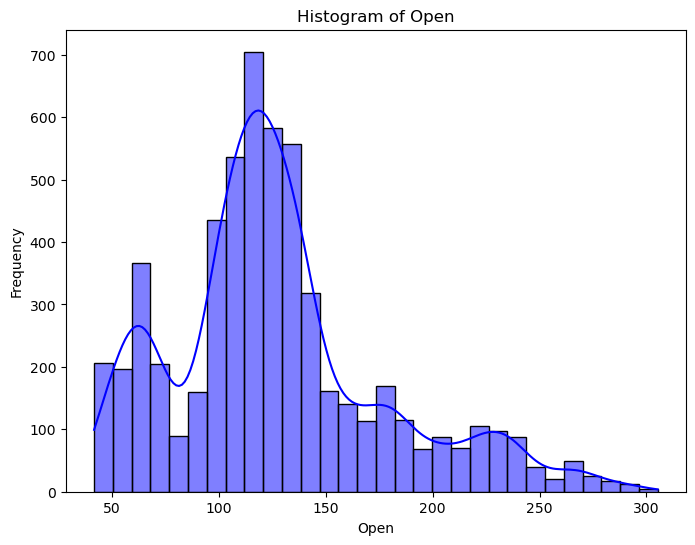

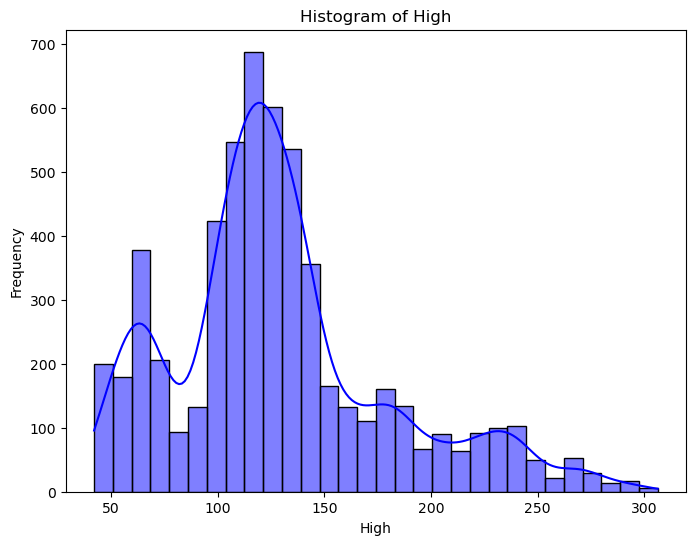

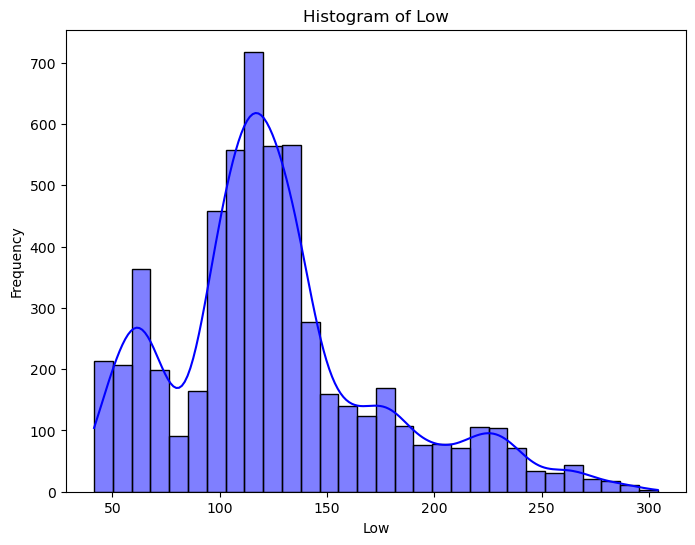

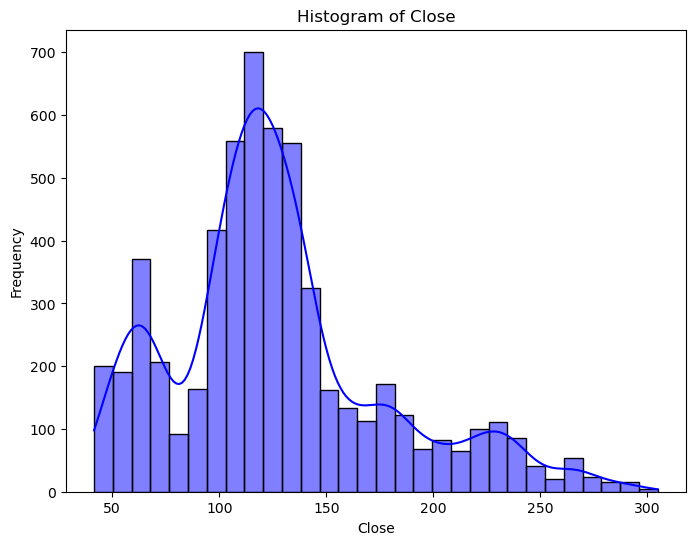

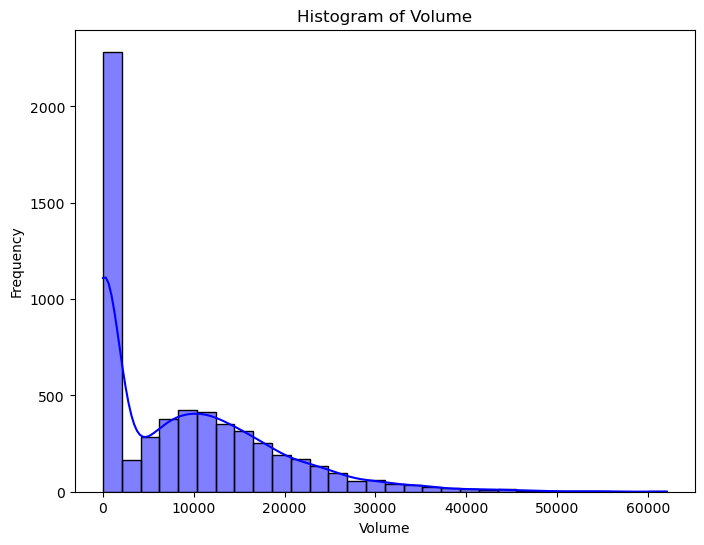

In [15]:
numerical_features = df.select_dtypes(include=['float64', 'int64'])

for column in numerical_features.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], bins=30, kde=True, color='blue')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

<Figure size 1200x1200 with 0 Axes>

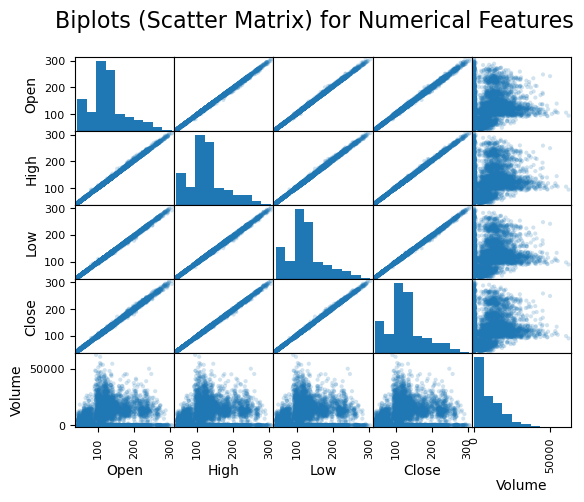

In [15]:
# biplots for feature combinations (scatter matrix)
plt.figure(figsize=(12, 12))
scatter_matrix(df[numerical_features.columns], alpha=0.2, diagonal='hist')
plt.suptitle('Biplots (Scatter Matrix) for Numerical Features', size=16)
plt.show()

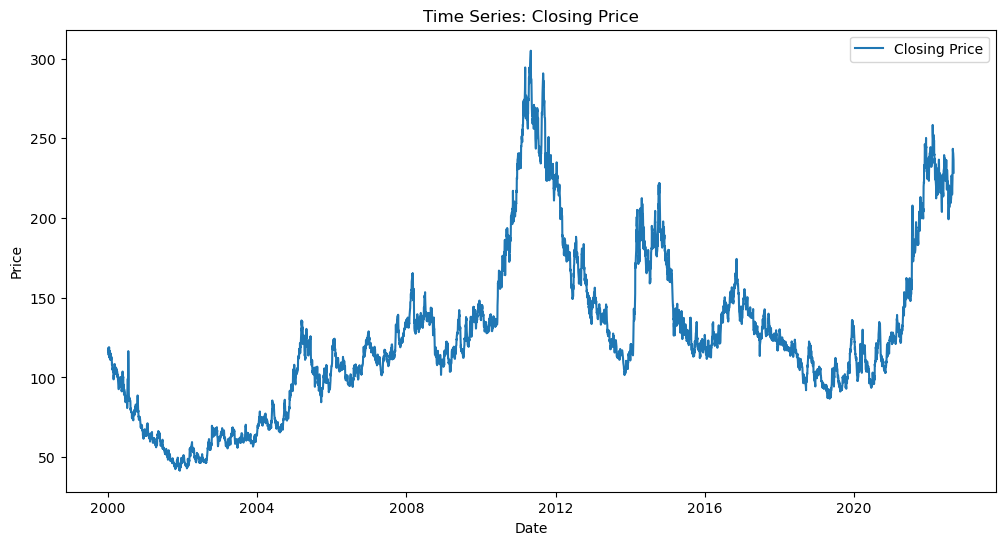

In [16]:
# Visualize time series data, this shows the closing price for the price of coffee over the wears by its price in USD.
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Closing Price')
plt.title('Time Series: Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

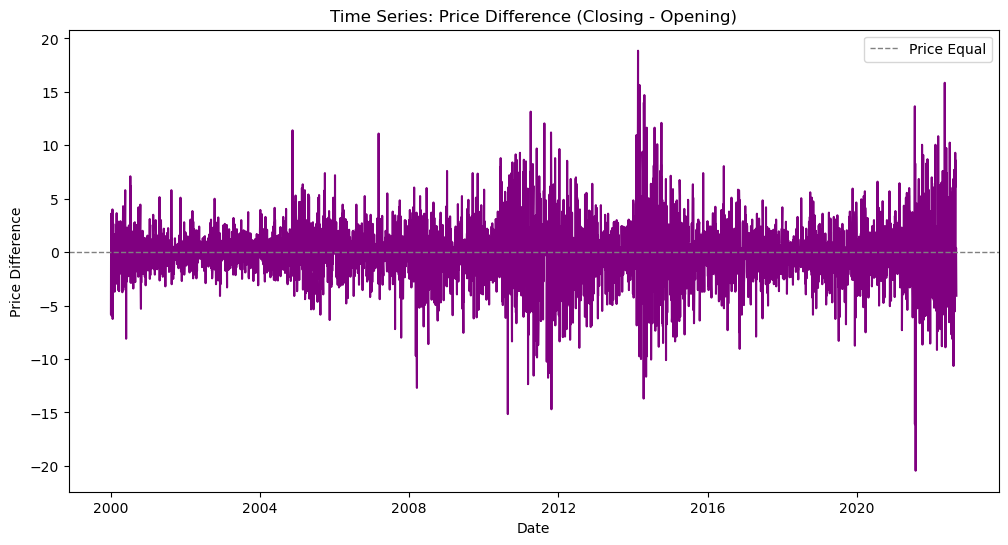

In [17]:
# Calculate the price difference (Close - Open)
df['Price Difference'] = df['Close'] - df['Open']

# Create a time series graph for the price difference
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price Difference'], color='purple')
plt.axhline(0, color='gray', linestyle='--', linewidth=1, label='Price Equal')
plt.title('Time Series: Price Difference (Closing - Opening)')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

In [18]:
# Calculate Pearson correlation coefficients
correlation_matrix = df.corr()

# Print the correlation matrix
print("Pearson Correlation Coefficients:")
print(correlation_matrix)

Pearson Correlation Coefficients:
                      Open      High       Low     Close    Volume  \
Open              1.000000  0.999366  0.999368  0.998644  0.111907   
High              0.999366  1.000000  0.999129  0.999346  0.120768   
Low               0.999368  0.999129  1.000000  0.999361  0.104490   
Close             0.998644  0.999346  0.999361  1.000000  0.113157   
Volume            0.111907  0.120768  0.104490  0.113157  1.000000   
Price Difference -0.049910 -0.024260 -0.024030  0.002157  0.021304   

                  Price Difference  
Open                     -0.049910  
High                     -0.024260  
Low                      -0.024030  
Close                     0.002157  
Volume                    0.021304  
Price Difference          1.000000  


C:\Users\chill\AppData\Local\Temp\ipykernel_21620\2075169858.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


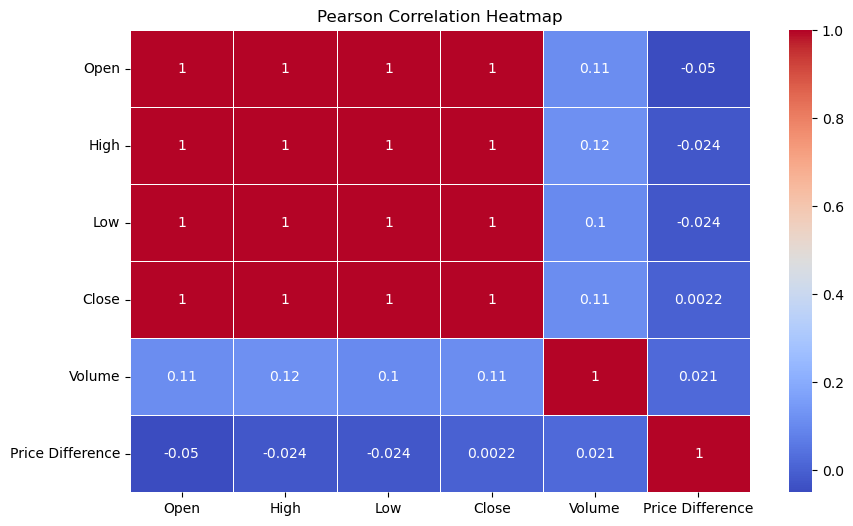

In [19]:
# correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

# EDA END

In [38]:
# Data preprocessing and training start
# create lag features for time series 
df['Close_Lag1'] = df['Close'].shift(1)

# take out non-numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns
df_imputed = df.copy()
for col in numerical_columns:
    imputer = SimpleImputer(strategy='mean')
    df_imputed[col] = imputer.fit_transform(df[[col]])

# scaler
scaler = StandardScaler()
df_imputed[numerical_columns] = scaler.fit_transform(df_imputed[numerical_columns])

# split data into training and test data
train_size = int(0.8 * len(df_imputed))
train_data, test_data = df_imputed[:train_size], df_imputed[train_size:]

# Extract features and target variable
X_train = train_data[['Close_Lag1']]
y_train = train_data['Close']
X_test = test_data[['Close_Lag1']]
y_test = test_data['Close']

Root Mean Squared Error (RMSE): 0.0645808093033592
Mean Absolute Error (MAE): 0.045590039632251354


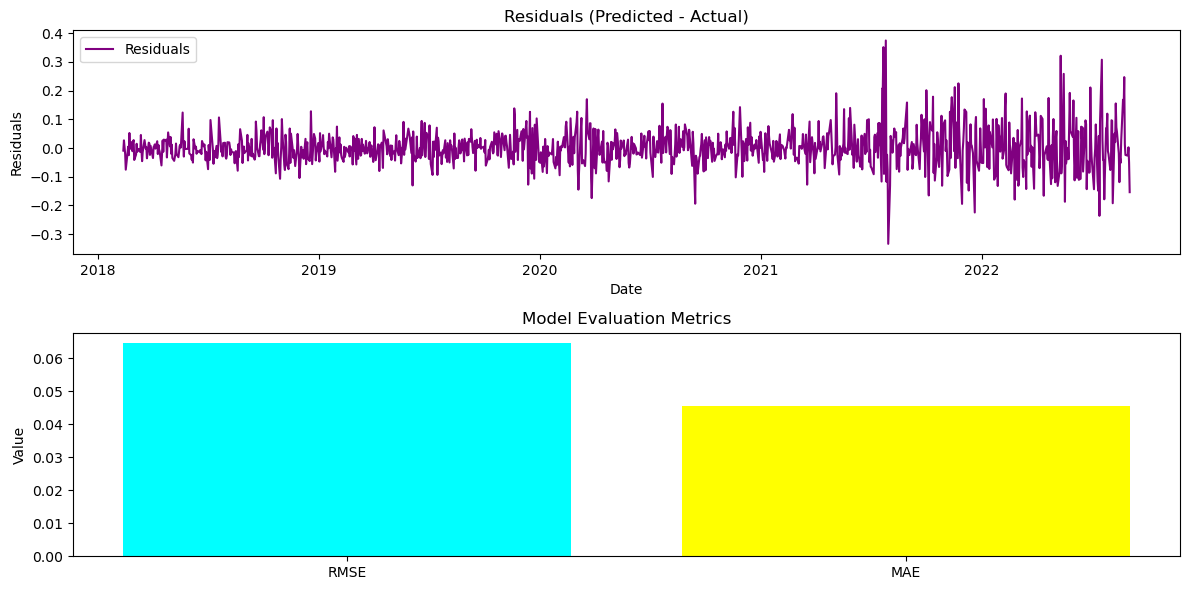

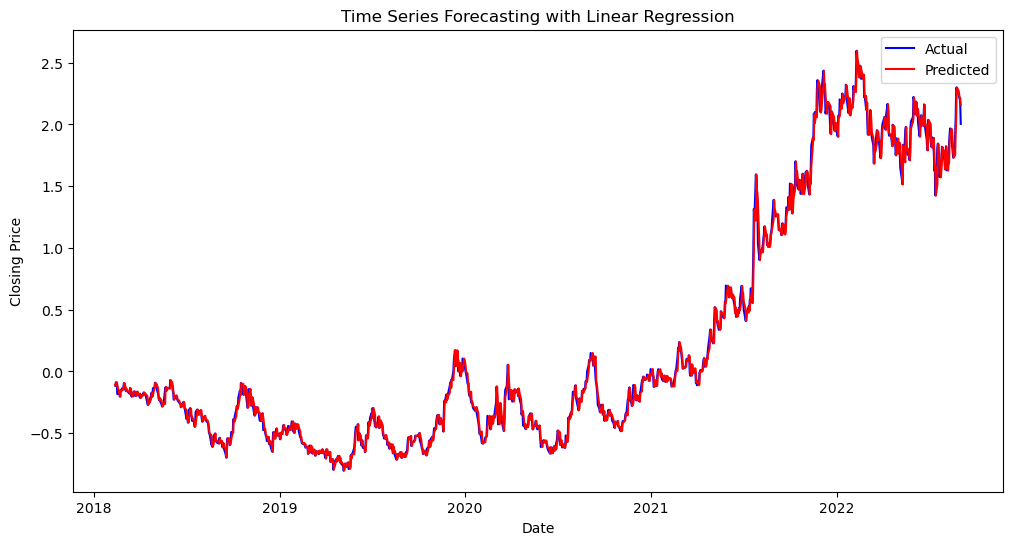

In [69]:
# Lin reg model 
model = LinearRegression()
model.fit(X_train, y_train)

# prediction
y_pred = model.predict(X_test)

# eval metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# residuals
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(test_data.index, residuals, label='Residuals', color='purple')
plt.title('Residuals (Predicted - Actual)')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()

# Plot RMSE and MAE separately
plt.subplot(2, 1, 2)
plt.bar(['RMSE', 'MAE'], [rmse, mae], color=['cyan', 'yellow'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Value')

plt.tight_layout()
plt.show()

# viz the predicitions 
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual', color='blue')
plt.plot(test_data.index, y_pred, label='Predicted', color='red')
plt.title('Time Series Forecasting with Linear Regression')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

Decision Tree Model Evaluation Metrics:
RMSE: 0.08403335719176573
MAE: 0.06054306551525955


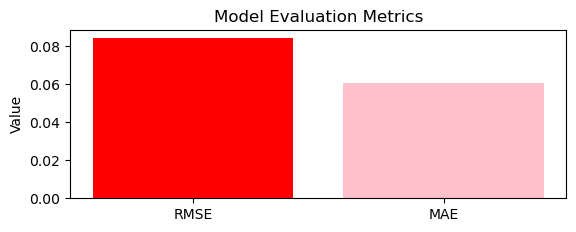

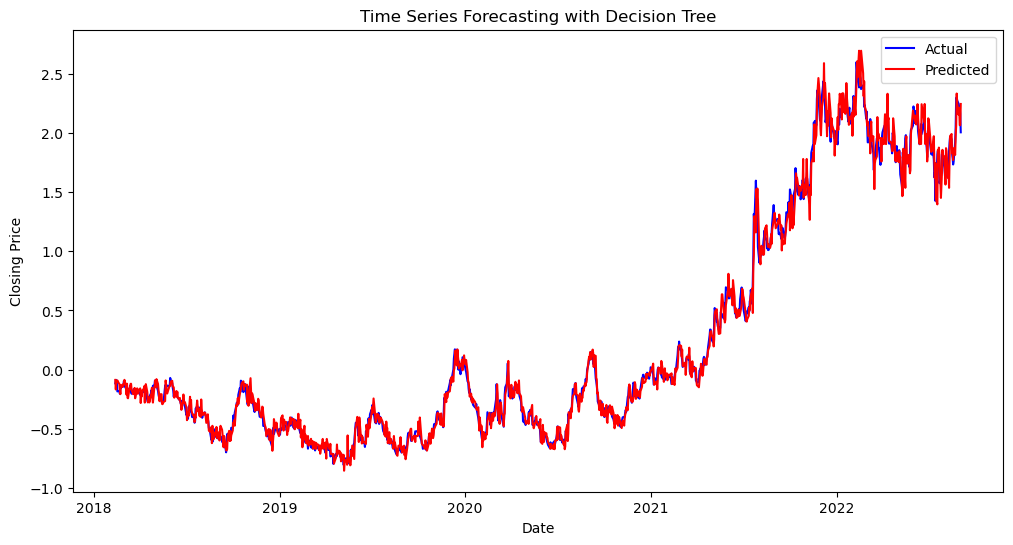

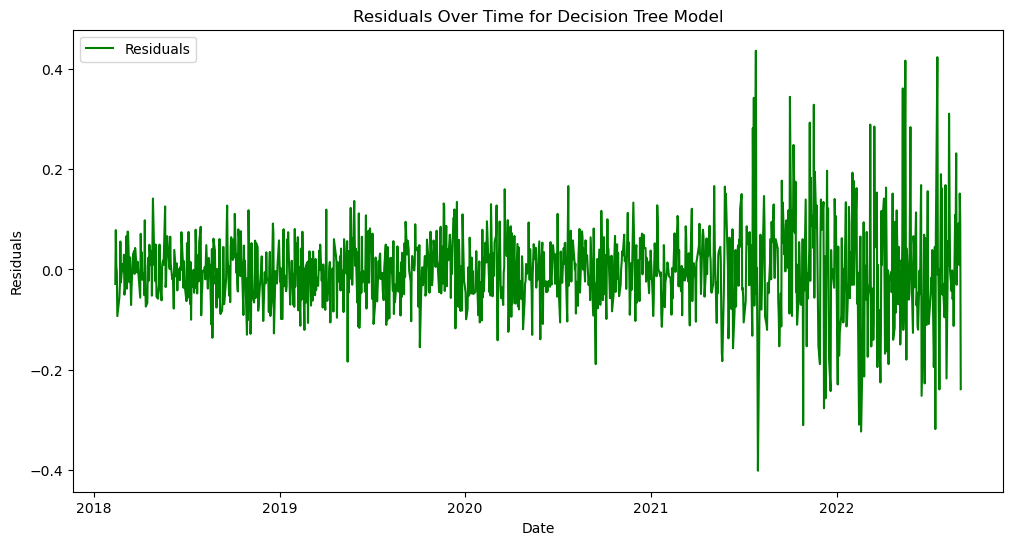

In [70]:
# dec tree model
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)

# predictions
y_pred_dt = decision_tree.predict(X_test)

# eval metric
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mae_dt = mean_absolute_error(y_test, y_pred_dt)

print("Decision Tree Model Evaluation Metrics:")
print(f"RMSE: {rmse_dt}")
print(f"MAE: {mae_dt}")


plt.subplot(2, 1, 2)
plt.bar(['RMSE', 'MAE'], [rmse_dt, mae_dt], color=['red', 'pink'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Value')
plt.tight_layout

# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual', color='blue')
plt.plot(X_test.index, y_pred_dt, label='Predicted', color='red')
plt.title('Time Series Forecasting with Decision Tree')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

#residuals
residualss = y_test - y_pred_dt

plt.figure(figsize=(12, 6))
plt.plot(X_test.index, residualss, label='Residuals', color='green')
plt.title('Residuals Over Time for Decision Tree Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

Random Forest Model Evaluation Metrics:
RMSE: 0.0762253713972701
MAE: 0.05502618180625991


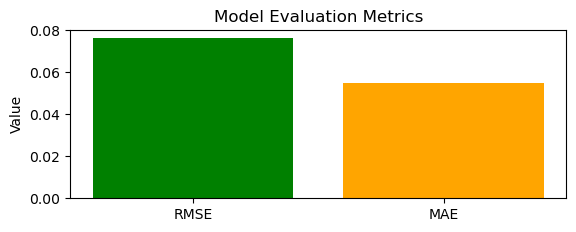

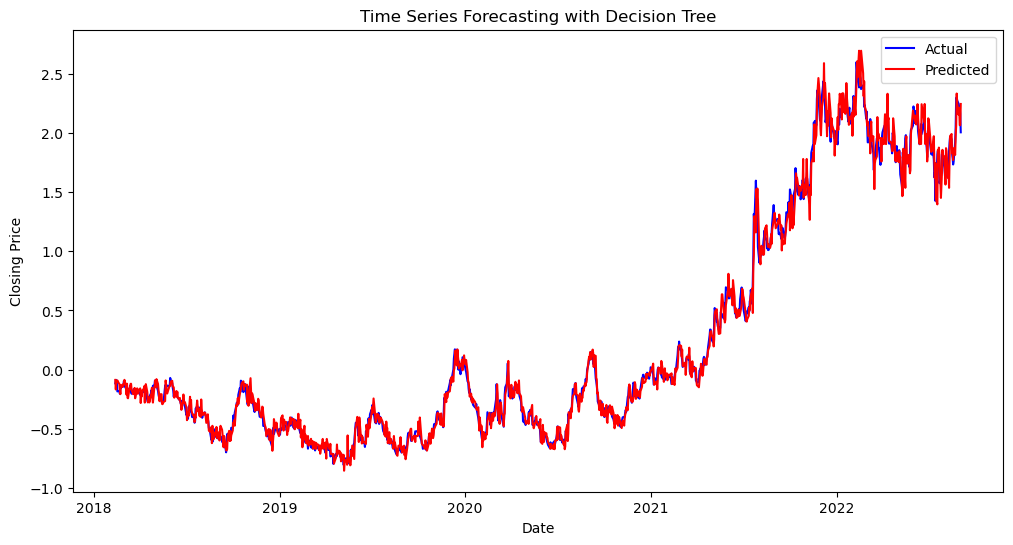

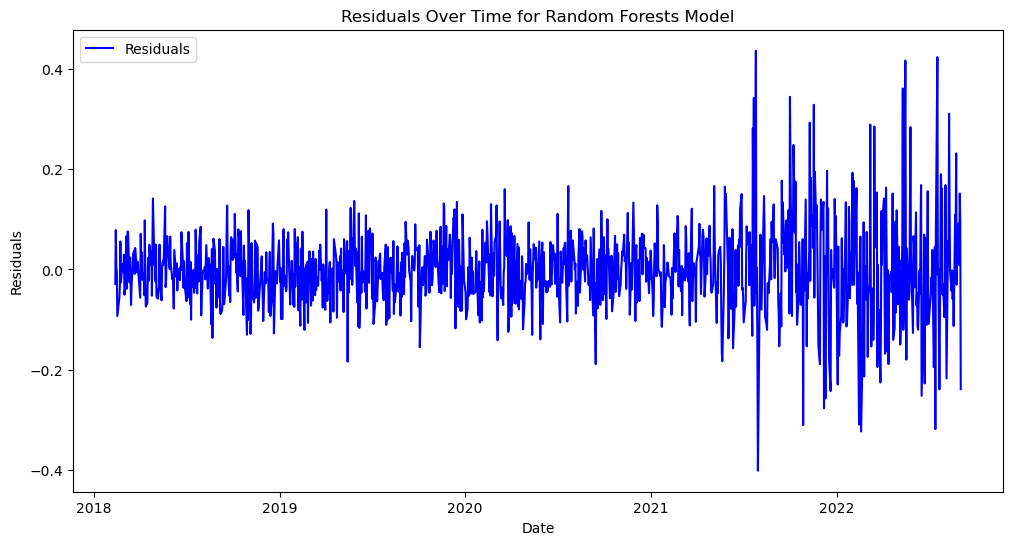

In [71]:
#random forests
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)

# prediction
y_pred_rf = random_forest.predict(X_test)

# eval metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("Random Forest Model Evaluation Metrics:")
print(f"RMSE: {rmse_rf}")
print(f"MAE: {mae_rf}")


plt.subplot(2, 1, 2)
plt.bar(['RMSE', 'MAE'], [rmse_rf, mae_rf], color=['green', 'orange'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Value')

plt.tight_layout

# Create a time series plot
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual', color='blue')
plt.plot(X_test.index, y_pred_dt, label='Predicted', color='red')
plt.title('Time Series Forecasting with Decision Tree')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# residuals
residuals1 = y_test - y_pred_dt

plt.figure(figsize=(12, 6))
plt.plot(X_test.index, residuals1, label='Residuals', color='blue')
plt.title('Residuals Over Time for Random Forests Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

Gradient Boosting Model Evaluation Metrics:
RMSE: 0.06814316145779592
MAE: 0.04817421875000925


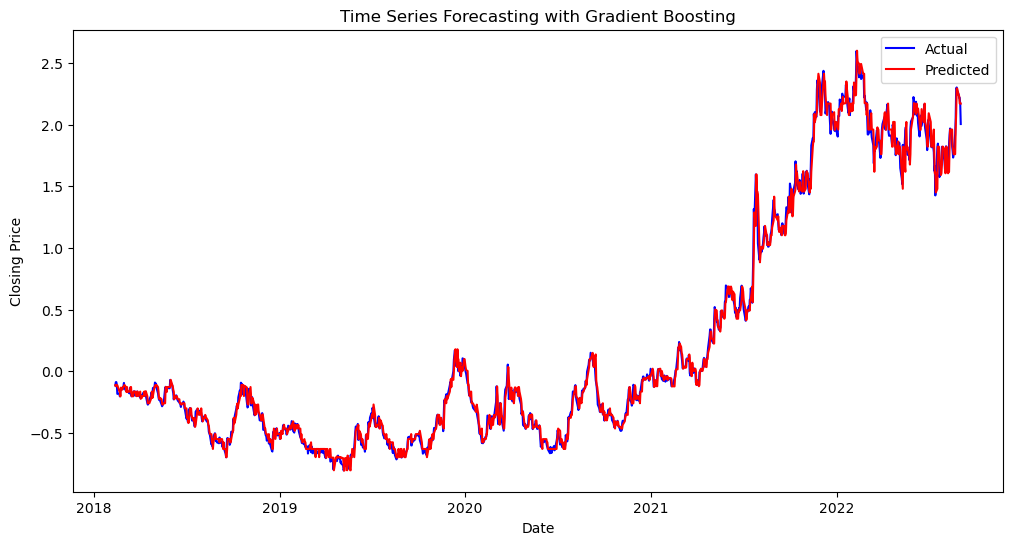

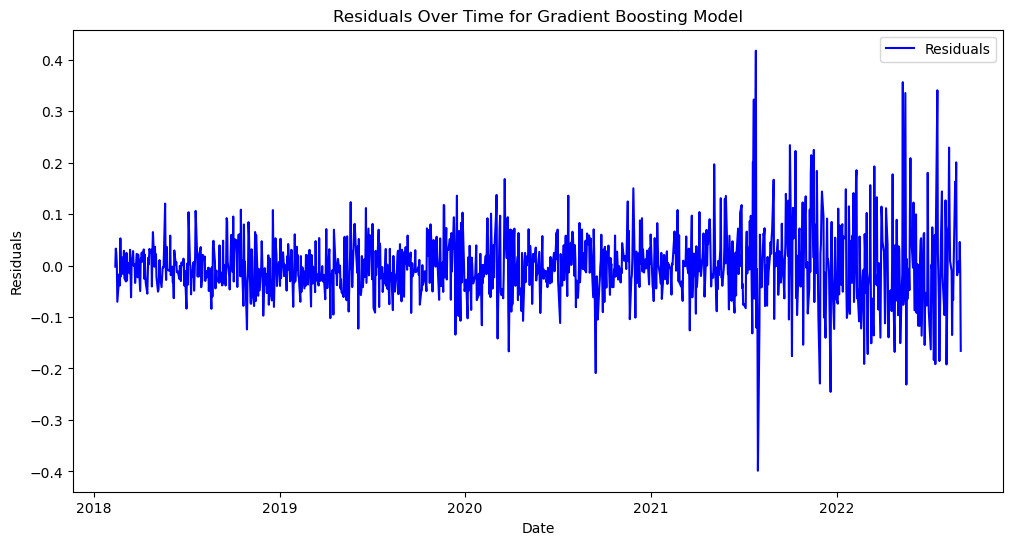

In [93]:
# gradient boosting
gradient_boosting = GradientBoostingRegressor()
gradient_boosting.fit(X_train, y_train)

# predictions 
y_pred_gb = gradient_boosting.predict(X_test)

# eval metric
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print("Gradient Boosting Model Evaluation Metrics:")
print(f"RMSE: {rmse_gb}")
print(f"MAE: {mae_gb}")

# time series
plt.figure(figsize=(12, 6))
plt.plot(X_test.index, y_test, label='Actual', color='blue')
plt.plot(X_test.index, y_pred_gb, label='Predicted', color='red')
plt.title('Time Series Forecasting with Gradient Boosting')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# residuals
residuals_gb = y_test - y_pred_gb

plt.figure(figsize=(12, 6))
plt.plot(X_test.index, residuals_gb, label='Residuals', color='blue')
plt.title('Residuals Over Time for Gradient Boosting Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()




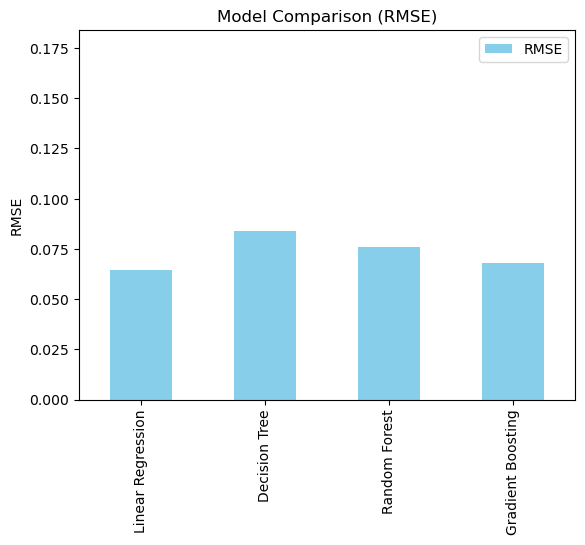

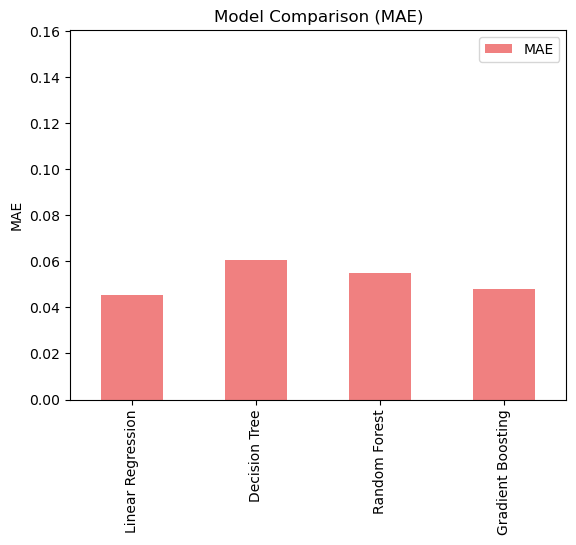

Linear Regression is the best model with an RMSE of 0.0646. RMSE measures the average prediction error.
Linear Regression is the best model with an MAE of 0.0456. MAE represents the mean absolute prediction error.


In [98]:
# models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

# Empty dictionaries for evaluation metrics
rmse_dict = {}
mae_dict = {}

# Iteration
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    rmse_dict[model_name] = rmse
    mae_dict[model_name] = mae

# Box plot for RMSE
rmse_df = pd.DataFrame(rmse_dict, index=['RMSE'])
rmse_df.T.plot(kind='bar', color='skyblue')
plt.title('Model Comparison (RMSE)')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_dict.values()) + 0.1)
plt.show()

# Box plot for MAE
mae_df = pd.DataFrame(mae_dict, index=['MAE'])
mae_df.T.plot(kind='bar', color='lightcoral')
plt.title('Model Comparison (MAE)')
plt.ylabel('MAE')
plt.ylim(0, max(mae_dict.values()) + 0.1)
plt.show()

# Find the best model based on RMSE
best_model_rmse = min(rmse_dict, key=rmse_dict.get)
best_rmse = rmse_dict[best_model_rmse]

# Find the best model based on MAE
best_model_mae = min(mae_dict, key=mae_dict.get)
best_mae = mae_dict[best_model_mae]

print(f"{best_model_rmse} is the best model with an RMSE of {best_rmse:.4f}. RMSE measures the average prediction error.")
print(f"{best_model_mae} is the best model with an MAE of {best_mae:.4f}. MAE represents the mean absolute prediction error.")